In [2]:
from spin_sim_src import *
import pickle as pickle

if __name__ == "__main__":
    print("This is main.py\n")

    # run: python <filename>.py <unique_number> <tfinal> <timesteps> <B0_start> <B0_stop> <B_steps>
    # <theta_start> <theta_stop> <theta_steps>
    #
    # theta is in units of pi
    #
    # for example: python cluster_do_colorplot.py 001 0.5e-3 500 0 1000e-6 100 0 1 100

    # transform command line arguments into the parameters  8 1.0e-3 100 0.0 1000.e-6 10 0.0 2.0 10

    unique_number = 8.
    tfinal = 1.0e-3
    timesteps = 100

    B_start = 0.0
    B_stop = 1000.0e-6
    B_steps = 10

    theta_start = 0.0 * np.pi
    theta_stop = 2.0 * np.pi
    theta_steps = 10

    # B0 = 47e-6 #T, B field of Earth at Frankfurt
    # theta = np.pi/4.0 #inclination of B field wrt to axis of RP, [0,pi]

    phi = 0. * np.pi / 1.0  # azimuth of B field, , [0,2*pi]

    mu0h = 9.274e-24 / 6.6e-34  # mu0 / h, 1/(T*s)
    a = [0., 0., 0.]
    a[0] = mu0h * 0.345e-4  # 0.345G given by PRE ; ax is now in Hz
    a[1] = mu0h * 0.345e-4  # 0.345G given by PRE ; ay is now in Hz
    a[2] = mu0h * 9e-4  # 9G given by PRE ; az is now in Hz
    # "Biologically feasible regime of HF strengths, 0.1 to 10G, see ref 26 in PRE"

    k = [0., 0., 0., 0.]
    k[0] = 2e4  # Hz, rate of decay into |S>
    k[1] = 2e4  # Hz, rate of decay into |T->
    k[2] = 2e4  # Hz, rate of decay into |T0>
    k[3] = 2e4  # Hz, rate of decay into |T+>

    # time array to simulate
    tinit = 0.0
    # tfinal = 1.0e-3
    # notimepoints = 1000.0

    times = np.linspace(tinit, tfinal, timesteps)  # in seconds
    timedetail = (tfinal - tinit) / timesteps
    # time zero is creation of RP

    num_states = 12

    # preparing the initial density matrices for various scenarios
    rho0_vectors, rho0_description = prep_ini_state()

    # adding dimensions to rho0 to account for the shelving states
    rho0 = rho_add_dim(total_num_states=num_states, rho0_vector=rho0_vectors[1])

    # coupling to bath or decay operators
    c_op_list = []

    P1 = 1.0 / np.sqrt(2.0) * basis(num_states, 8) * (basis(num_states, 2).dag() - basis(num_states, 4).dag())
    P2 = 1.0 / np.sqrt(2.0) * basis(num_states, 8) * (basis(num_states, 3).dag() - basis(num_states, 5).dag())
    P3 = 1.0 / np.sqrt(2.0) * basis(num_states, 10) * (basis(num_states, 2).dag() + basis(num_states, 4).dag())
    P4 = 1.0 / np.sqrt(2.0) * basis(num_states, 10) * (basis(num_states, 3).dag() + basis(num_states, 5).dag())
    P5 = basis(num_states, 11) * basis(num_states, 0).dag()
    P6 = basis(num_states, 11) * basis(num_states, 1).dag()
    P7 = basis(num_states, 9) * basis(num_states, 6).dag()
    P8 = basis(num_states, 9) * basis(num_states, 7).dag()

    c_op_list.append(np.sqrt(k[0]) * P1)
    c_op_list.append(np.sqrt(k[0]) * P2)
    c_op_list.append(np.sqrt(k[1]) * P3)
    c_op_list.append(np.sqrt(k[1]) * P4)
    c_op_list.append(np.sqrt(k[2]) * P5)
    c_op_list.append(np.sqrt(k[2]) * P6)
    c_op_list.append(np.sqrt(k[3]) * P7)
    c_op_list.append(np.sqrt(k[3]) * P8)

    ex_op_list = []

    # define the arrays to calculate the B-field and the theta angles
    do_log_bfield_scan = False
    if do_log_bfield_scan:
        B0_arr = np.logspace(np.log10(B_start), np.log10(B_stop), B_steps)  # in T, 100 is usual
    else:
        B0_arr = np.linspace(B_start, B_stop, B_steps)  # in T, 100 is usual

    theta_arr = np.linspace(theta_start, theta_stop, theta_steps)  # rad, 100 is usual

    result_S = []
    result_S_formula = []
    # pops_tot = np.zeros([len(B0_arr), len(theta_arr), len(times), number_of_states])
    pops_tot = np.zeros([len(B0_arr), len(theta_arr), num_states])

    l0 = 0

    for B0 in B0_arr:

        l1 = 0

        print("B-field = " + str(B0))

        for theta in theta_arr:
            print("   Theta = " + str(theta))

            # building the Hamiltonian
            h = build_Hamiltonian(a, B0, theta, phi)

            # adding the shelving states as additional dimensions to the Hamiltonian
            H = hamiltonian_add_dim(total_num_states=num_states, hamiltonian=h)

            SYend, SYform, pops = time_evol(H, rho0, num_states, times, timesteps, timedetail, k, c_op_list, ex_op_list)
            result_S.append(SYend)
            result_S_formula.append(SYform)
            # pops_tot[l0,l1,:,:] = pops
            pops_tot[l0, l1, :] = pops[-1, :]  # only save the last time point

            l1 += 1

        l0 += 1

    pickle.dump([result_S, result_S_formula, pops_tot, B0_arr, theta_arr, phi, a[0], a[1], a[2], k[0], k[1], tfinal,
                 timedetail, rho0], open("Data_" + rho0_description[1] + ".p", "wb"))

    print("Done.")


This is main.py

B-field = 0.0
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.00011111111111111112
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.00022222222222222223
   Theta = 0.0
   Theta = 0.6981317007977318
   Theta = 1.3962634015954636
   Theta = 2.0943951023931953
   Theta = 2.792526803190927
   Theta = 3.490658503988659
   Theta = 4.1887902047863905
   Theta = 4.886921905584122
   Theta = 5.585053606381854
   Theta = 6.283185307179586
B-field = 0.0003333333333333334
   Theta = 0.0
   Theta = 0.698

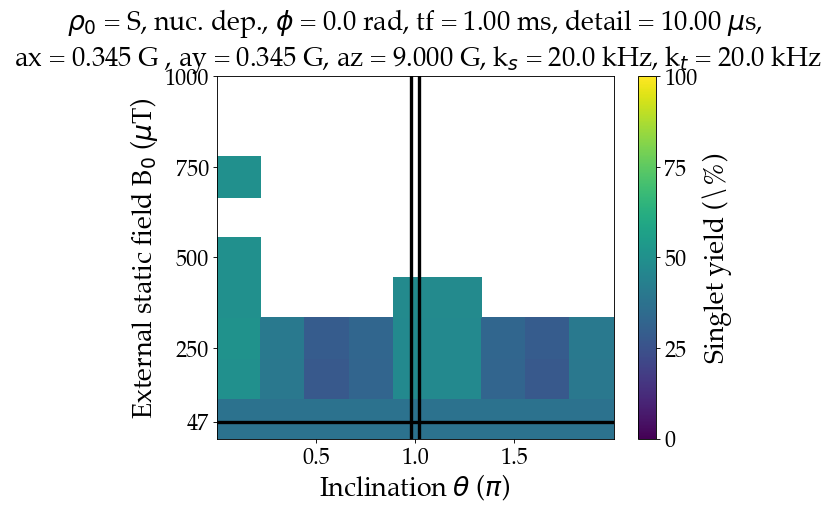

NameError: name 'ax' is not defined

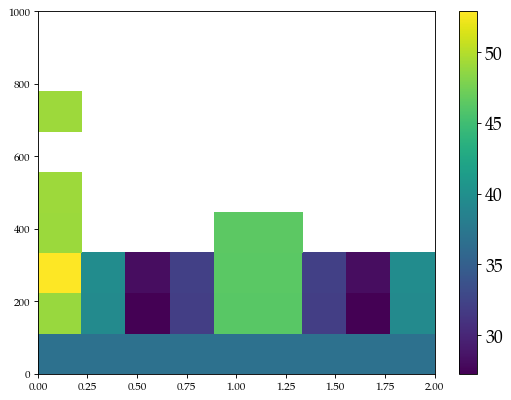

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
#sys.path.append("/usr/bin") # necessary for the tex fonts
#sys.path.append("../Python modules/") # necessary for the tex fonts

fsizetit = 24
fsizepl = 20
sizex = 8
sizey = 6
fsizenb = 16
dpi_no = 80
lw = 2

mu0h = 9.274e-24/6.6e-34 #mu0 / h, 1/(T*s)
phi = 0.0
###############################################################################

data = pickle.load(open( "Data_S, nuc. dep..p", "rb" ))
rho0_description = 'S, nuc. dep.'
#data = pickle.load( open( "Data_Elecs. dep., nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tzero, nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tminus, nuc. dep._complete.p", "rb" ) ,encoding='latin1')
#data = pickle.load( open( "Data_Tplus, nuc. dep._complete.p", "rb" ) ,encoding='latin1')

#for k in [8,9,10,11]:
#    plt.figure()
#    plt.imshow(d[2][:, :, k])
#    plt.colorbar()
#    plt.title('State: ' + str(k))
#
#plt.show()


result_S = 100*np.array(data[0]).reshape(len(data[3]),len(data[4]))
result_S_formula = 100*np.array(data[1]).reshape(len(data[3]),len(data[4]))

#fig 1 
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', serif='Palatino')  
plt.pcolor(data[4]/np.pi,data[3]*1e6,result_S,vmin=0, vmax=100) 
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsizepl)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(data[5])) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(data[11]*1e3)) + ' ms, detail = ' + str("{0:.2f}".format(data[12]*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(data[6]/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(data[7]/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(data[8]/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(data[9]/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(data[10]/1000.0)) + ' kHz', fontsize = fsizetit)
plt.ylabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizetit)
plt.xlabel(r'Inclination $\theta$ ($\pi$)',fontsize = fsizetit)
cbar.ax.set_ylabel(r'Singlet yield (\%)',fontsize = fsizetit)
cbar.set_ticks([0, 25, 50, 75, 100])
plt.xticks([0.5, 1, 1.5],fontsize=fsizepl)
plt.yticks([47, 250, 500,750, 1000],fontsize=fsizepl)
plt.axhline(y=47, xmin=0, xmax=2*np.pi, linewidth=3, color = 'k')
plt.ylim([data[3][0]*1e6,data[3][-1]*1e6])
plt.axvline(x=0.98,linewidth=3, color = 'k')
plt.axvline(x=1.02,linewidth=3, color = 'k')


plt.show()



#fig 2 - to check if it's like fig 1
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
plt.pcolor(data[4]/np.pi,data[3]*1e6,result_S_formula) #,cmap='Greys') #, vmin=z_min, vmax=z_max)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsizenb)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(phi)) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(tfinal*1e3)) + ' ms, detail = ' + str("{0:.2f}".format(timedetail*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(ax/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(ay/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(az/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(ks/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(kt/1000.0)) + ' kHz', fontsize = fsizetit)
plt.ylabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizepl)
plt.xlabel(r'Inclination $\theta$ ($\pi$)',fontsize = fsizepl)
cbar.ax.set_ylabel(r'Singlet yield (\%)',fontsize = fsizepl)
plt.xticks(fontsize=fsizenb)
plt.yticks(fontsize=fsizenb)


#fig 3
plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
plt.plot(data[3]*1e6, np.nanmax(result_S, axis = 1)-np.nanmin(result_S, axis = 1)) #Sensitivity vs B0
plt.legend()
plt.xlabel(r'External static field B$_0$ ($\mu$T)',fontsize = fsizepl)
plt.ylabel(r'Sensitivity (\%)',fontsize = fsizepl)
plt.ylim([0,25])
plt.xlim([0,1000])
plt.xticks(fontsize=fsizenb)
plt.yticks(fontsize=fsizenb)
plt.title(r'$\rho_0$ = ' + rho0_description + ', $\phi$ = ' + str("{0:.1f}".format(phi)) + ' rad, ' + r'tf = ' +  str("{0:.2f}".format(tfinal*1e3)) + ' ms, detail = ' + str("{0:.1f}".format(timedetail*1e6)) + r' $\mu$s,' + '\n ax = ' + str("{0:.3f}".format(ax/mu0h*1e4)) + ' G , ay = ' + str("{0:.3f}".format(ay/mu0h*1e4)) + ' G, az = ' + str("{0:.3f}".format(az/mu0h*1e4)) + ' G, ' + r'k$_s$ = ' + str("{0:.1f}".format(ks/1000.0)) + ' kHz, ' + 'k$_t$ = ' + str("{0:.1f}".format(kt/1000.0)) + ' kHz', fontsize = fsizetit)


#    plt.figure(figsize=(sizex, sizey), dpi=dpi_no)
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('font', serif='Palatino')  
#    my_labels = ['uuu','uud','udu','udd','duu','dud','ddu','ddd','S recombined','T$_+$ recombined','T$_0$ recombined','T$_-$ recombined']
#    for k in range(number_of_states):
#        if k > 7:
#            my_ls = '--'
#            my_label = my_labels[k]
#        else:
#            my_label = my_labels[k]
#            
#            my_label = my_label.replace('u',r'$\uparrow$')
#            my_label = my_label.replace('d',r'$\downarrow$')
#    
#            my_ls = '-'
#    
#        plt.plot(times*(1e6), pops_tot[:, k], label = my_label, ls = my_ls)
#    plt.legend()
#    plt.xlabel('Time after RP creation [$\mu$s]')
#    plt.ylabel('Populations')
#    plt.ylim([0,0.52])

multipage(rho0_description[k] + '.pdf')
plt.close("all")

#plt.show()

In [11]:
print(data)

[[0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.37521745780854776, 0.4970480518506571, 0.40149895099525157, 0.27709466540892674, 0.32403716461857146, 0.4700376700819084, 0.4700376700819047, 0.3240371646183392, 0.27709466543872835, 0.4014989506593515, 0.4970479197493577, 0.5106214882125254, 0.4038938999791631, 0.28539521204721424, 0.32688992974786885, 0.4722972008212088, 0.4722972008212075, 0.3268899287789506, 0.2853952201403408, 0.40389389997932673, 0.5106213412963473, 0.49967507511740467, nan, nan, nan, 0.4727074406766203, 0.4727074406766102, nan, nan, nan, 0.49967507505170206, 0.49981354647082127, nan, nan, nan, nan, nan, nan, nan, nan, 0.49981354651118176, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.4999165329445018, nan, nan, nan, nan, nan, nan, nan, nan, 0.49991656619795993, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

In [2]:
from spin_sim_src import *

num_states = 12

P1 = 1.0 / np.sqrt(2.0) * basis(num_states, 8) * (basis(num_states, 2).dag() - basis(num_states, 4).dag())

print(P1)

Quantum object: dims = [[12], [12]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.      

In [5]:
basis(2,0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

In [21]:
#
# Dynamics of radical pair subjected to Geomagnetic field
#
from qutip import *
from scipy import *
from pylab import *
import math
import csv


# problem parameters:
pi=math.pi
muB = 5.788*10**-5  # Bohr Magneton in eV/Tesla
g=2 # g-factor for electron
gama=muB*g # in eV/Tesla
gama=gama*0.1519756*10**16 # in sec-1/Tesla (Converted using natural units, by taking hbar=1)
#B0=47*10**-6 # Geomagnetic field in Frankfurt (Tesla)
#B0=46*10**-6 # Geomagnetic field in Frankfurt (Tesla)
Brf=150*10**-9 # Disturbing RF field of strength 150 nanoTesla
w = 2*pi*1.316*10**6      # Frequency of externally applied RF field
sqrt2=math.sqrt(2)

# Initial State
up=basis(2,0)
down=basis(2,1)
singlet=(tensor(up,down)-tensor(down,up))/sqrt2 # Initial State of the radical pair
trip0=(tensor(up,down)+tensor(down,up))/sqrt2 # Triplet state with zero spin
tripu= tensor(up,up) # Tirplet state with spin +1
tripd=tensor(down,down) # Triplet state with spin -1

# Initial State
e_dm=singlet*singlet.dag()
nuc_dm=0.5*qeye(2)
rho=tensor(nuc_dm,e_dm)
rho0=Qobj(pad(rho.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))

# For Local Coherence
elec_dm=singlet*singlet.dag()
elec_array=elec_dm.full()
elec_array[1][1]=0   # Making diagonal elements of density matrix to zero
elec_array[2][2]=0
elec_offd=Qobj(elec_array)
nuc_dm=0.5*qeye(2)
rho_d=tensor(nuc_dm,elec_offd)
rho0_offd=Qobj(pad(rho_d.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))

# Defining Hamiltonian operators
S1x=tensor(qeye(2),sigmax(),qeye(2))
S2x=tensor(qeye(2),qeye(2),sigmax())
S1x_10=Qobj(pad(S1x.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0))) # pad() function increases the size of array of S1x from  
#8x8 to 10x10 and put 0s at the newly created places
S2x_10=Qobj(pad(S2x.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
Sx=S1x_10+S2x_10
S1y=tensor(qeye(2),sigmay(),qeye(2))
S2y=tensor(qeye(2),qeye(2),sigmay())
S1y_10=Qobj(pad(S1y.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
S2y_10=Qobj(pad(S2y.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
Sy=S1y_10+S2y_10
S1z=tensor(qeye(2),sigmaz(),qeye(2))
S2z=tensor(qeye(2),qeye(2),sigmaz())
S1z_10=Qobj(pad(S1z.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
S2z_10=Qobj(pad(S2z.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
Sz=S1z_10+S2z_10
#ISx8=tensor(sigmax(),sigmax(),qeye(2))
ISx8=tensor(sigmax(),qeye(2),sigmax())
#ISy8=tensor(sigmay(),sigmay(),qeye(2))
ISy8=tensor(sigmay(),qeye(2),sigmay())
#ISz8=tensor(sigmaz(),sigmaz(),qeye(2))
ISz8=tensor(sigmaz(),qeye(2),sigmaz())
ISx=Qobj(pad(ISx8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
ISy=Qobj(pad(ISy8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))
ISz=Qobj(pad(ISz8.full(), ((0, 2), (0, 2)), 'constant', constant_values=(0)))

# Geomagnetic field angle (in radian)
theta_list=linspace(0.0, pi/2, 25)
#theta_list=linspace(pi/2, pi, 1)
noa=len(theta_list)

# Defining Zeeman Field Window
#B0=[0,10**-6,20**-6,30**-6,40**-6,50**-6,60**-6,70**-6,80**-6,90**-6,100**-6]
#B=logspace(log10(float(0.01)),log10(100),100)
B=logspace(log10(float(0.01)),log10(1000),50)
B0=[x*10**-6 for x in B]
loB=len(B0)
print('B values',loB)
# Magnetic field made zero for calculating coherence
#B0_coh=0


# Hyperfine Coupling Constants (in eV)
B_geo=47*10**-6
print('Geomagnetic field = ', B_geo)
#a=logspace(log10(10**-2),log10(10**2),200)
#a=logspace(log10(5),log10(10**2),20)
#a=10
#ax=gama*B_geo*4
#ay=gama*B_geo*3
#az=0
#a=logspace(log10(float(1.00)),log10(20),1)
#az=[x*gama*B0 for x in a]
#loa=len(az)
#print('No of hyperfines = ', loa)

#ax=0.100*5*10**-9
#ay=0.100*5*10**-9
#az=1.3*10**-8
#ax=ax*0.1519756*10**16 # in per-sec
#ay=ay*0.1519756*10**16 # in per-sec
#az=az*0.1519756*10**16 # in per-sec
ax=0.3455 # In Gauss
ay=0.3455 # In Gauss
az=9.0 # In Gauss

ax=ax*10**-4 # in Tesla
ay=ay*10**-4 # in Tesla
az=az*10**-4 # in Tesla

ax=ax*muB # in eV
ay=ay*muB # in eV
az=az*muB # in eV

ax=ax*0.1519756*10**16 # in per-sec
ay=ay*0.1519756*10**16 # in per-sec
az=az*0.1519756*10**16 # in per-sec

# Decay rates [These three rates are simulated]
#k=5*10**4
ks=2*10**4
kt=2*10**4
k=2*10**4
#lok=len(k)
print('ks = ', ks)
print('kt = ', kt)

# Time steps in Integration. It would take 6/k time to decay the population by almost 99%
tlist=[]
tlist = linspace(0.0, float(6)/k, 3000) # Defining time instants for simulation
noe=len(tlist)
dt=tlist[1]-tlist[0]
print("dt = ", dt)

# Defining Projection operators    

P=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s

P1=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P1[8][1]=1/sqrt2
P1[8][2]=-1/sqrt2
P1=sqrt(ks)*Qobj(P1)

P2=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P2[8][5]=1/sqrt2
P2[8][6]=-1/sqrt2
P2=sqrt(ks)*Qobj(P2)

P3=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P3[9][1]=1/sqrt2
P3[9][2]=1/sqrt2
P3=sqrt(kt)*Qobj(P3)

P4=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P4[9][5]=1/sqrt2
P4[9][6]=1/sqrt2
P4=sqrt(kt)*Qobj(P4)

P5=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P5[9][0]=1
P5=sqrt(kt)*Qobj(P5)

P6=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P6[9][3]=1
P6=sqrt(kt)*Qobj(P6)

P7=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P7[9][4]=1
P7=sqrt(kt)*Qobj(P7)

P8=[[0 for x in range(10)] for x in range(10)] # 10x10 array containing only 0s
P8[9][7]=1
P8=sqrt(kt)*Qobj(P8)

# Defining Collapse Operators
c_op_list = [P1,P2,P3,P4,P5,P6,P7,P8]

# Variables
sensitivity=[]
coherence=[]

for lb in range(0,loB):  # Loop over various hyperfine constant values
    singlet_yield=[] # Storing Singlet yield for
    singlet_yield_coh=[] # Defining Singlet Yield variable
    triplet_yield=[] # Defining Triplet Yield variable
    Cohr=0
    for th in range(0,noa): # Loop over various angle values
        Bx=B0[lb]*sin(theta_list[th])
        By=0
        Bz=B0[lb]*cos(theta_list[th])
        #Brfx = Brf*sin(3*pi/2+theta_list[th])
        #Brfy = 0
        #Brfz = Brf*cos(3*pi/2+theta_list[th])

        H0 = 0.5*gama*Bx*Sx + 0.5*gama*By*Sy + 0.5*gama*Bz*Sz + 0.25*ax*ISx + 0.25*ay*ISy + 0.25*az*ISz
        #H0 = gama*Bx*Sx/2 + gama*By*Sy/2 + gama*Bz*Sz/2 + ax*ISx/4 + ay*ISy/4 + az*ISz/4
        #H0 = Bx*Sx/2 + By*Sy/2 + Bz*Sz/2 + ax*ISx/4 + ay*ISy/4 + az*ISz/4

        #H1 = gama*Brfx*Sx + gama*Brfy*Sy + gama*Brfz*Sz
        #args={'w':w}
        #H=[H0,[H1,'cos(w*t)']]
            # Running the Master Equation solver
        opts = Odeoptions(nsteps=5000)

        result = mesolve(H0, rho0, tlist, c_op_list, [],options=opts)
        #result_coh = mesolve(H0_coh, rho0_offd, tlist, c_op_list, [],options=opts)
        #print('theta = ', theta_list[th],"Done")
        #result = mesolve(H, rho0, tlist, c_op_list, [], args=args, options=None) # Hamiltonian with RF field also.
        #rh_ss=steadystate(H, c_op_list,maxiter=500, tol=1e-06, method='mesolve')

            # Output states of the differential equation solver
        rh=[]
        rh_coh=[]
        rh_static=[]
        rh=result.states
        singlet_yield.append(abs(rh[noe-1][8][0][8]))
        #singlet_yield_coh.append(abs(rh_coh[noe-1][8][0][8]))
        triplet_yield.append(abs(rh[noe-1][9][0][9]))

    print('B0 = ', B0[lb], 'Done!')
    Sens=max(singlet_yield)-min(singlet_yield)
    print('Sensitivity = ', Sens)
    sensitivity.append(Sens)
    #Cohr=max(singlet_yield_coh)
    #coherence.append(Cohr)

# Saving data to a file
ar_data=array([B,sensitivity])
fl = open('data/FW_ax0.3455G_ay0.3455G_az8.5G_k2104.csv', 'w')
writer = csv.writer(fl)
writer.writerow(['Magnetic Field (microTesla)', 'Sensitivity']) #if needed
for values in ar_data:
    writer.writerow(values)
fl.close()




B values 50
Geomagnetic field =  4.7e-05
ks =  20000
kt =  20000
dt =  1.0003334444814938e-07
B0 =  1e-08 Done!
Sensitivity =  0.0009021498777093129
B0 =  1.2648552168552958e-08 Done!
Sensitivity =  0.0014382303655455786
B0 =  1.5998587196060583e-08 Done!
Sensitivity =  0.002288043627136749
B0 =  2.0235896477251575e-08 Done!
Sensitivity =  0.003627821007178622
B0 =  2.5595479226995356e-08 Done!
Sensitivity =  0.005721650589656069
B0 =  3.2374575428176436e-08 Done!
Sensitivity =  0.008948688773996183
B0 =  4.0949150623804256e-08 Done!
Sensitivity =  0.013813782593987523
B0 =  5.1794746792312124e-08 Done!
Sensitivity =  0.02089862814917709
B0 =  6.551285568595509e-08 Done!
Sensitivity =  0.03067760101131034
B0 =  8.286427728546843e-08 Done!
Sensitivity =  0.04313644880681111
B0 =  1.0481131341546857e-07 Done!
Sensitivity =  0.057355337460004596
B0 =  1.3257113655901095e-07 Done!
Sensitivity =  0.0717280565391995
B0 =  1.6768329368110082e-07 Done!
Sensitivity =  0.08518173300929688
B0 =  

In [22]:
print(singlet_yield)

[0.4987236180540427, 0.49866139435010387, 0.49847442350116383, 0.4981690440737438, 0.4977543033739633, 0.49724088174430664, 0.49664107098610977, 0.49597174049536336, 0.4952478114042023, 0.4944848269378422, 0.4937001489129288, 0.4929073955806722, 0.49212201497682906, 0.49135789596151164, 0.49062540020032247, 0.4899356199721108, 0.4892971650337425, 0.48871767246260023, 0.4882057095198194, 0.48776341060647876, 0.48739956147615493, 0.4871129710607031, 0.48699577453130943, 0.48682476003825315, 0.48673910732485637]


In [23]:
print(triplet_yield)

[0.49879762976929704, 0.49885985347325507, 0.49904682432218334, 0.49935220374953837, 0.49976694444947184, 0.5002803660791693, 0.5008801768372824, 0.5015495073280507, 0.5022734364191693, 0.5030364208854192, 0.5038210989103414, 0.5046138522426173, 0.5053992328464966, 0.5061633518618909, 0.5068958476231012, 0.5075856278512315, 0.5082240827896596, 0.5088035753607086, 0.5093155383035495, 0.5097578372169674, 0.5101216863471961, 0.5104082767625356, 0.5105254732921013, 0.5106964877851156, 0.5107821404984392]


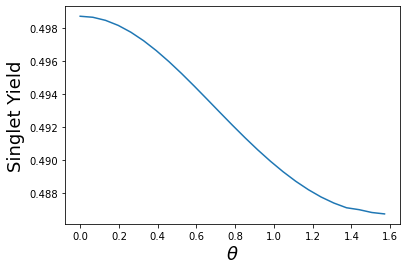

In [24]:
import matplotlib.pyplot as plt


figure()
#ylim([0.00,0.20])
plt.plot(theta_list, singlet_yield)
#plot(B,sensitivity,'r')
xlabel(r"$\theta$",fontsize=18)
ylabel('Singlet Yield', fontsize=18 )
savefig('Figures/SY_ax0.3455G_ay0.3455G_az8.5G_k2104.eps')
savefig('Figures/SY_ax0.3455G_ay0.3455G_az8.5G_k2104.pdf')

show()

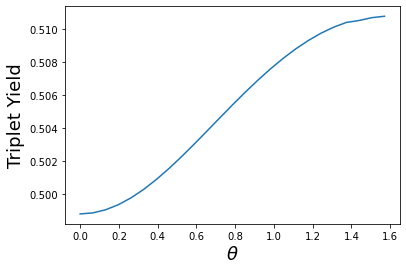

In [25]:
figure()
#ylim([0.00,0.20])
plt.plot(theta_list, triplet_yield)
#plot(B,sensitivity,'r')
xlabel(r"$\theta$",fontsize=18)
ylabel('Triplet Yield', fontsize=18 )
savefig('Figures/TY_ax0.3455G_ay0.3455G_az8.5G_k2104.eps')
savefig('Figures/TY_ax0.3455G_ay0.3455G_az8.5G_k2104.pdf')

show()

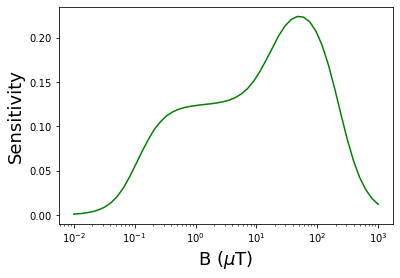

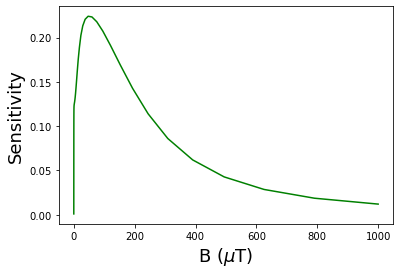

In [26]:

#Plotting Sensitivity/Singlet Yield
figure()
#ylim([0.00,0.20])
semilogx(B,sensitivity,'g')
#plot(B,sensitivity,'r')
xlabel("B ($\mu$T)",fontsize=18)
ylabel('Sensitivity', fontsize=18 )
savefig('Figures/FW_ax0.3455G_ay0.3455G_az8.5G_k2104.eps')
savefig('Figures/FW_ax0.3455G_ay0.3455G_az8.5G_k2104.pdf')

figure()
plot(B,sensitivity,'g')
xlabel("B ($\mu$T)",fontsize=18)
ylabel('Sensitivity', fontsize=18 )
savefig('Figures/FW_ax0.3455G_ay0.3455G_az8.5G_k2104_Linear.eps')
savefig('Figures/FW_ax0.3455G_ay0.3455G_az8.5G_k2104_Linear.pdf')

show()